# Running MultiDGD with strict feature selection

Although MultiDGD performs very well on datasets with all transcripts and peaks, it can also be run with feature selection. This notebook demonstrates how the feature selection function works and was created in response to an issue on GitHub.

In [ ]:
import os
import requests, zipfile
import numpy as np
import anndata as ad
import scanpy as sc

import multiDGD
from multiDGD.utils import *

os.chdir('..')

### Load data

In [ ]:
# Download
data_dir = 'data/'

# permission was denied for automatic download, so the files were manually downloaded and placed in the data directory

file_name1 = '10x-Multiome-Pbmc10k-RNA.h5ad'
file_url1 = 'http://download.gao-lab.org/GLUE/dataset/10x-Multiome-Pbmc10k-RNA.h5ad'

file_name2 = '10x-Multiome-Pbmc10k-ATAC.h5ad'
file_url2 = 'http://download.gao-lab.org/GLUE/dataset/10x-Multiome-Pbmc10k-ATAC.h5ad'

In [3]:
rna_data = ad.read_h5ad('./data/'+file_name1)
atac_data = ad.read_h5ad('./data/'+file_name2)

In [9]:
rna_data.X.max() # seems to be raw counts

5585.0

### Perform an extreme example of feature selection

In [34]:
import mudata as md

data = md.MuData({'rna':rna_data, 'atac':atac_data})
# selecting the top 2000 RNA features and 30000 ATAC features wrt the variance
_, data, _ = multiDGD.functions.sc_feature_selection(data, ['rna', 'atac'], feature_selection=[2000,30000])
# alternatively we can use the percentage of cells with an active feature as a threshold
#_, data, _ = multiDGD.functions.sc_feature_selection(data, ['rna', 'atac'], feature_selection=0.05) # 5 percent of cells
data.obs = rna_data.obs

data

/opt/anaconda3/envs/omics/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/opt/anaconda3/envs/omics/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/opt/anaconda3/envs/omics/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the

MuData object with n_obs × n_vars = 9631 × 32000
  obs:	'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'observable', 'train_val_test'
  var:	'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'
  2 modalities
    rna:	9631 x 2000
      obs:	'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'observable', 'train_val_test'
      var:	'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac:	9631 x 30000
      obs:	'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
      var:	'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'

### Prepare the dataset for MultiDGD and initialize the model

In [35]:
data = multiDGD.functions._data.setup_data(data, observable_key='cell_type')

In [36]:
model = multiDGD.DGD(data=data, save_dir="./models/", model_name="dgd_gao_pbmc")
model.view_data_setup()

selected  19  number of Gaussian mixture components based on the provided observable.
The prepared data consists of the following training set:

        omicsDataset:
            Number of samples: 7704
            Modalities: ['rna', 'atac']
            Features per modality: [2000, 30000]
            Total number of features: 32000
            Scaling of values: sum
        
There is also a validation set with 963 samples
And a test set with 964 samples


### Train the model and visualize the results

Preparing data loaders
Now training
training for  500  epochs with early stopping ( loss )


Training: 100%|██████████| 500/500 [40:35<00:00,  4.87s/epochs, loss=0.862, reconstruction_loss=0.839]


#######################
Training status
#######################
True


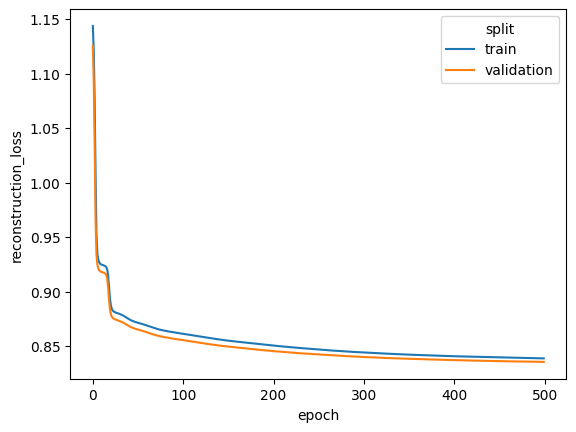

In [37]:
model.train(n_epochs=500)
model.plot_history()

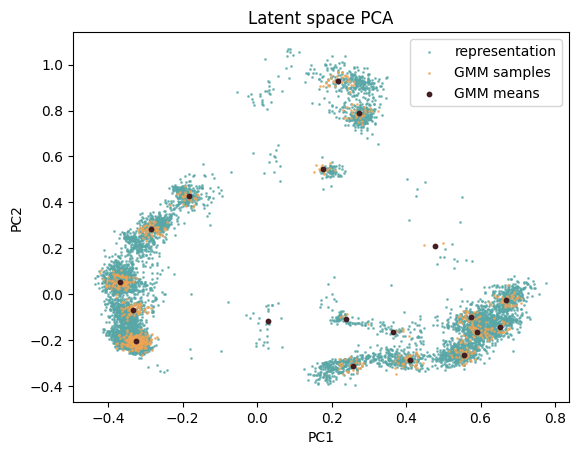

In [38]:
model.plot_latent_space()

/opt/anaconda3/envs/omics/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/opt/anaconda3/envs/omics/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/opt/anaconda3/envs/omics/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the

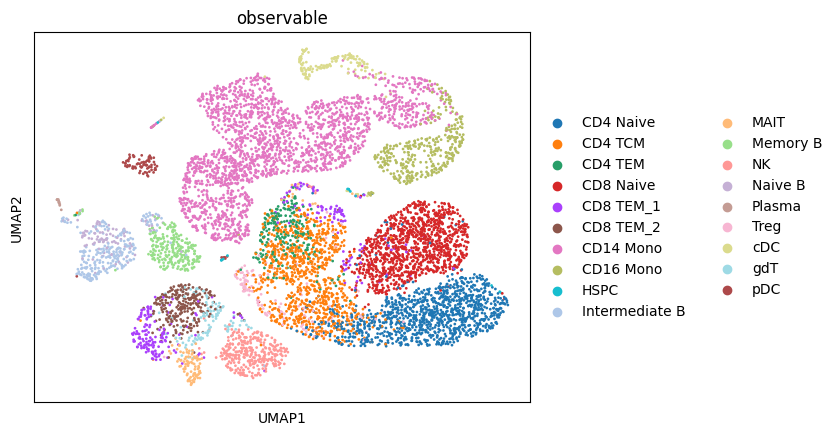

In [40]:
# visualize embeddings (scanpy conform)
# of the training data first
data_train = data.copy()[data.obs['train_val_test'] == 'train']
data_train.obsm['latent'] = model.get_representation()

sc.pp.neighbors(adata=data_train, use_rep='latent', n_neighbors=10)
sc.tl.umap(data_train, min_dist=1.0)
sc.pl.umap(data_train, color='observable')